In [ ]:
!pip install sentence_transformers faiss-cpu matplotlib

In [2]:
import math
import pandas as pd 
import torch
import matplotlib.pyplot as plt
import os
import glob

from sentence_transformers import SentenceTransformer

In [ ]:
df = pd.read_csv("data/simulation_data.csv")

display(f"Found {len(df)} rows.")

In [ ]:
RELEVANT_COLUMNS = ["input_text", "target_txt", "output_meta-llama_Llama-3.2-3B-Instruct", "output_meta-llama_Llama-3.1-8B-Instruct", "output_meta-llama_Llama-3.3-70B-Instruct"]

MINIBATCH_SIZE = 1024
NUM_CHUNKS = math.ceil(len(df) / MINIBATCH_SIZE)


In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device="cuda" if torch.cuda.is_available() else "cpu")
display(f"Model running on {model.device}.")

for col in RELEVANT_COLUMNS:
    emb_list = []
    for idx, minibatch in enumerate(range(NUM_CHUNKS)):
        min_idx = minibatch * MINIBATCH_SIZE
        max_idx = (minibatch + 1) * MINIBATCH_SIZE - 1

        text_input = df.loc[min_idx: max_idx, col].tolist()
        embeddings = model.encode(text_input)
        emb_list += [i for i in embeddings]

    display(len(emb_list))
    df[f"{col}_embed"] = pd.Series(emb_list).astype(object)

In [ ]:
def compute_distance(row, col_1: str, col_2: str): 
    distance = torch.sqrt(
        torch.sum(
            torch.pow(
                torch.subtract(torch.tensor(row[f"{col_1}_embed"]), torch.tensor(row[f"{col_2}_embed"])), 
                2
            ), 
            dim=0
        )
    )  
    return distance.item()

DISTANCE_TUPLES = {
    "3b-8b": ("output_meta-llama_Llama-3.2-3B-Instruct", "output_meta-llama_Llama-3.1-8B-Instruct"),
    "3b-70b": ("output_meta-llama_Llama-3.2-3B-Instruct", "output_meta-llama_Llama-3.3-70B-Instruct"),
    "8b-70b": ("output_meta-llama_Llama-3.1-8B-Instruct", "output_meta-llama_Llama-3.3-70B-Instruct"),
    "3b-target_txt": ("output_meta-llama_Llama-3.2-3B-Instruct", "target_txt"),
    "8b-target_txt": ("output_meta-llama_Llama-3.1-8B-Instruct", "target_txt"),
    "70b-target_txt": ("output_meta-llama_Llama-3.3-70B-Instruct", "target_txt"),
}

for k, dist_tuple in DISTANCE_TUPLES.items(): 
    df[f"dist_{k}"] = df.apply(lambda row: compute_distance(row, col_1=dist_tuple[0], col_2=dist_tuple[1]), axis=1)

In [ ]:
for dist in DISTANCE_TUPLES.keys(): 
    display(f"Distance statistics between model {dist}: {round(df[f'dist_{dist}'].min(), 4)} (Min.) - {round(df[f'dist_{dist}'].max(), 4)} (Max.) - {round(df[f'dist_{dist}'].mean(), 4)} (Avg.) - {round(df[f'dist_{dist}'].std(), 4)} (Std.Dev.).")


In [ ]:
CHUNK_SIZE = 1000
NUM_CHUNKS = int(len(df) / CHUNK_SIZE)

for idx, chunk in enumerate(range(NUM_CHUNKS)):
    min_idx = idx * CHUNK_SIZE
    max_idx = (idx + 1) * CHUNK_SIZE - 1

    df.loc[min_idx: max_idx].to_parquet(f"data/sentence_transformer_embeddings/data_chunk_{idx}.parquet", index=None)


In [26]:
df_test = pd.read_parquet(f"data/sentence_transformer_embeddings/data_chunk_1.parquet")

In [4]:
display(df_test.loc[3000, "target_txt_embed"])

array([-1.74004666e-03, -2.23796978e-03,  3.74957547e-02, -1.02234706e-02,
        7.76794106e-02,  3.98207754e-02, -1.05262930e-02,  1.29920319e-02,
       -1.04747124e-01, -8.24390631e-03,  2.05260087e-02, -8.63364805e-03,
       -1.71148051e-02,  2.39389371e-02, -1.03658875e-02, -1.16256149e-02,
       -2.88991015e-02, -3.32117788e-02, -1.26792818e-01, -8.64633545e-03,
       -1.03339665e-02, -1.83805656e-02,  2.60190237e-02, -4.86015752e-02,
       -4.20669280e-02, -3.68275195e-02,  6.24631196e-02, -6.46939799e-02,
        2.79593766e-02,  3.66472267e-02, -2.07238570e-02, -1.18935127e-02,
       -5.20533957e-02, -5.71092125e-03, -3.65023986e-02,  1.81146730e-02,
        5.75629696e-02, -1.20269656e-02, -1.02160620e-02,  1.51121290e-02,
        3.35738547e-02, -1.14121931e-02, -2.13363972e-02, -5.16641028e-02,
        6.94205612e-02, -1.47264125e-03, -4.67739627e-03, -8.15976858e-02,
       -1.00058995e-01, -9.14961025e-02,  9.46687534e-02, -5.55385686e-02,
       -2.12671887e-03, -

In [5]:
df_test.head()

,input_text,target_txt,output_meta-llama_Llama-3.2-3B-Instruct,energy_meta-llama_Llama-3.2-3B-Instruct,time_meta-llama_Llama-3.2-3B-Instruct,flesch_reading_ease,smog_index,automated_readability_index,lexical_diversity,syllable_count,...,output_meta-llama_Llama-3.1-8B-Instruct_embed,output_meta-llama_Llama-3.3-70B-Instruct_embed,dist_3b-8b,dist_3b-70b,dist_8b-70b,dist_3b-target_txt,dist_8b-target_txt,dist_70b-target_txt,input_text_modern_bert_embed,input_text_modern_bert_pca_{pca_dim}_dims
3000,Betrifft: Einbeziehung der Gleichstellungspoli...,Subject: 'Mainstreaming' in EU aid policy In 1...,The subject: Incorporation of equal opportunit...,0.063762,0.00008,3.80,0.0,31.4,0.800000,53,...,"[-0.04792585, -0.010700069, 0.08068846, -0.010...","[-0.078781, 0.0066580228, 0.025055101, 0.02878...",0.627189,0.790197,0.751832,0.791355,0.796145,0.772703,None,None
3001,"Die Leitlinien verlangen, daß alle Mitarbeiter...",The guidelines call for all staff working in t...,The guidelines require that all employees invo...,0.063762,0.00008,30.70,0.0,21.3,0.957447,84,...,"[0.009265082, -0.0072213956, 0.0034087782, -0....","[0.031469993, -0.014911046, 0.06092614, -0.021...",0.616962,0.465144,0.516403,0.883771,0.838016,0.918877,None,None
3002,Die Einbeziehung des Gleichstellungsaspekts in...,'Mainstreaming' means taking account of equali...,Inclusion of the equality aspect in all activi...,0.063762,0.00008,22.08,0.0,29.8,0.812500,58,...,"[0.06654537, 0.0006522401, 0.0026087372, -0.00...","[0.04825454, -0.003820474, -0.0020084984, -0.0...",0.383137,0.408785,0.369025,0.632801,0.674695,0.663968,None,None
3003,"Um dies zu ermöglichen, müssen die Leitlinien ...","To achieve that, the Council's guidelines must...","To enable this, the guidelines of the Council ...",0.063762,0.00008,30.87,0.0,17.8,0.933333,28,...,"[-0.035519417, 0.024957813, -0.03183221, -0.02...","[-0.008836397, -0.013464713, -0.004884338, -0....",0.665113,0.810256,0.631742,0.790608,0.715893,0.806614,None,None
3004,Die Bediensteten müssen eine obligatorische Sc...,Current staff must receive compulsory training...,Employees must receive mandatory training on e...,0.063762,0.00008,9.22,0.0,30.6,0.928571,56,...,"[-0.03161143, -0.000726508, -0.019773902, -0.0...","[-0.048005544, 0.0032131567, 0.04573092, -0.00...",0.634892,0.484343,0.567150,0.870987,0.846736,0.782099,None,None


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 3000 to 3999
Data columns (total 43 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   input_text                                      1000 non-null   object 
 1   target_txt                                      1000 non-null   object 
 2   output_meta-llama_Llama-3.2-3B-Instruct         1000 non-null   object 
 3   energy_meta-llama_Llama-3.2-3B-Instruct         1000 non-null   float64
 4   time_meta-llama_Llama-3.2-3B-Instruct           1000 non-null   float64
 5   flesch_reading_ease                             1000 non-null   float64
 6   smog_index                                      1000 non-null   float64
 7   automated_readability_index                     1000 non-null   float64
 8   lexical_diversity                               1000 non-null   float64
 9   syllable_count                        

In [27]:
parquet_directory = "data/sentence_transformer_embeddings/"
parquet_files = glob.glob(os.path.join(parquet_directory, "data_chunk_*.parquet"))

df_combined = pd.concat([pd.read_parquet(file) for file in parquet_files], ignore_index=True)

df_combined

,input_text,target_txt,output_meta-llama_Llama-3.2-3B-Instruct,energy_meta-llama_Llama-3.2-3B-Instruct,time_meta-llama_Llama-3.2-3B-Instruct,flesch_reading_ease,smog_index,automated_readability_index,lexical_diversity,syllable_count,...,output_meta-llama_Llama-3.1-8B-Instruct_embed,output_meta-llama_Llama-3.3-70B-Instruct_embed,dist_3b-8b,dist_3b-70b,dist_8b-70b,dist_3b-target_txt,dist_8b-target_txt,dist_70b-target_txt,input_text_modern_bert_embed,input_text_modern_bert_pca_{pca_dim}_dims
0,Südafrika verfügt über ein enormes Potential.,"Mr President, South Africa has enormous potent...",South Africa has enormous potential.,0.062460,0.000078,56.93,0.0,13.0,1.000000,10,...,"[0.00032566025, -0.04445372, -0.05286541, 0.01...","[0.00032566025, -0.04445372, -0.05286541, 0.01...",0.000000,0.000000e+00,0.000000e+00,0.623788,0.623788,0.623788,None,None
1,"Es gibt so vieles, wovon erst so wenige profit...",There is so much there which so few have enjoyed.,There is so much that only a few have benefite...,0.062460,0.000078,95.17,0.0,6.2,0.900000,12,...,"[0.097804375, -0.06715146, 0.0028192739, -0.00...","[0.08887976, -0.011383782, 0.038048424, 0.0207...",0.769150,6.248255e-01,8.240398e-01,1.027102,1.060792,1.047107,None,None
2,"Wirtschaftswachstum ist eine notwendige, aber ...",Economic growth is a necessary but not an adeq...,Economic growth is a necessary but insufficien...,0.062460,0.000078,34.93,0.0,23.4,1.000000,21,...,"[-0.0024234643, 0.030609226, -0.017322429, 0.0...","[-0.0024234264, 0.030609224, -0.017322425, 0.0...",0.326815,3.268146e-01,4.758111e-07,0.334336,0.209100,0.209100,None,None
3,Es geht um die bessere Verteilung und richtige...,What is needed is for resources to be better d...,It's about the better distribution and proper ...,0.062460,0.000078,90.09,0.0,15.9,1.000000,18,...,"[0.040162064, 0.030467393, 0.011293916, -0.006...","[0.008753527, 0.028484786, -0.0055298605, 0.03...",0.631596,4.581256e-07,6.315963e-01,0.734692,0.925370,0.734692,None,None
4,"Das Apartheidregime wurde abgeschafft, nun muß...","The apartheid regime has been abolished, all t...","'The apartheid regime was abolished, but apart...",0.062460,0.000078,85.69,0.0,16.6,1.000000,14,...,"[-0.028619155, 0.06970561, 0.024402136, 0.0595...","[-0.02605756, 0.056993067, 0.023479814, 0.0488...",0.362537,3.539744e-01,1.135696e-01,0.550469,0.479459,0.476413,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48995,Die letzten Wochen waren geprägt durch zahlrei...,The last few weeks have been marked by a serie...,The last weeks were marked by numerous reprisa...,0.075839,0.000100,42.38,0.0,16.7,1.000000,21,...,"[0.00207426, -0.027758773, 0.005920697, -3.375...","[0.0159986, -0.070241496, 0.016286755, 0.01258...",0.522830,3.037246e-01,4.960974e-01,0.656776,0.689338,0.579282,None,None
48996,Sie reichen von hohen Geldstrafen bis hin zu u...,This ranged from high fines to direct intimida...,They range from high fines to immediate intimi...,0.075839,0.000100,44.41,0.0,15.6,1.000000,18,...,"[0.018336384, 0.031020774, 0.011399053, -0.050...","[0.018832171, 0.030512234, 0.012462552, -0.043...",0.000000,6.426050e-02,6.426050e-02,0.522156,0.522156,0.534960,None,None
48997,Außerdem ist eine Art innere Isolation zu beob...,"In addition, there is talk of a kind of intern...","Also, eine Art innerer Isolation zu beobachten.",0.075839,0.000100,63.36,0.0,9.7,1.000000,13,...,"[-0.025794752, -0.03485997, 0.015114336, 0.092...","[-0.034276463, -0.06389915, 0.002580156, 0.077...",1.052699,1.071942e+00,4.329710e-01,1.115268,0.777562,0.706237,None,None
48998,Die Einreise in das Land wird zunehmend erschw...,It is increasingly difficult to enter the coun...,'The entry into the country is becoming increa...,0.075839,0.000100,80.28,0.0,7.9,1.000000,11,...,"[0.07389671, -0.0802001, 0.040514916, 0.033637...","[0.07389671, -0.08020012, 0.040514894, 0.03363...",0.351728,3.517283e-01,6.024378e-07,0.537368,0.409481,0.409481,None,None


In [29]:
distance_columns = [
    'dist_3b-8b',
    'dist_3b-70b',
    'dist_8b-70b',
    'dist_3b-target_txt',
    'dist_8b-target_txt',
    'dist_70b-target_txt'
]

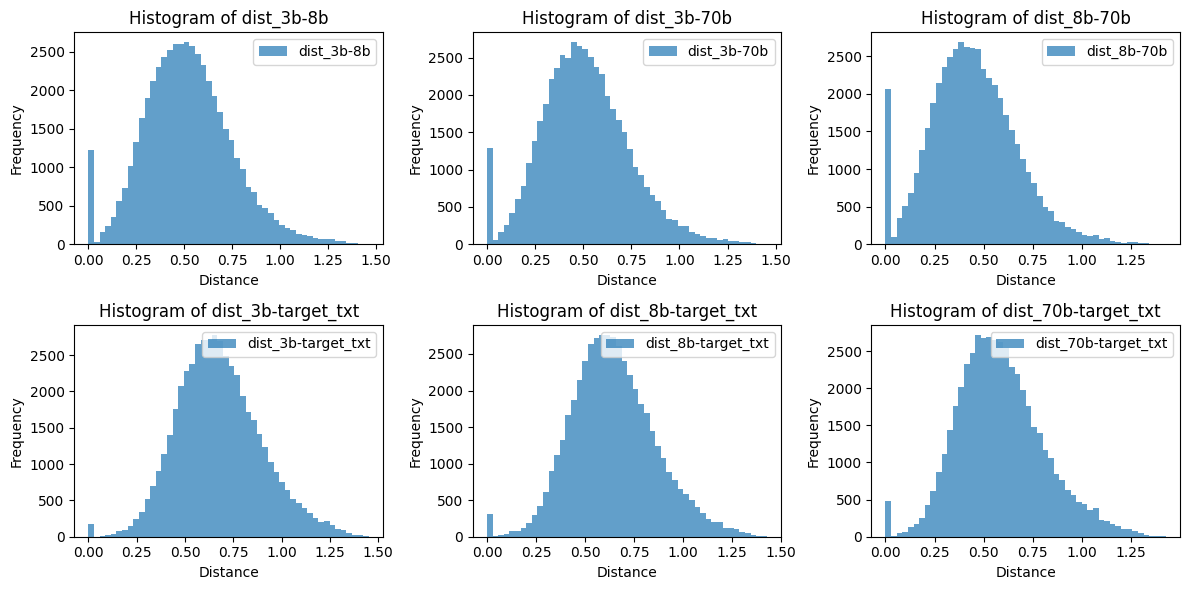

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for i, column in enumerate(distance_columns):
    axes[i].hist(df_combined[column], bins=50, alpha=0.7, label=column)
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Distance")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.tight_layout()

plt.savefig("figures/distance_histogram.png")
plt.show()